In [24]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
def analytical_solution(x,t):
    return np.exp(-t) * np.sin(x)

def f(x,t):
    return np.cos(x) * np.exp(-t)

def phiL(t):
    return np.exp(-t)

def phiR(t):
    return -np.exp(-t)

def psi1(x):
    return np.sin(x)

def psi2(x):
    return -np.sin(x)

def dx_psi1(x):
    return np.cos(x)

def ddx_psi1(x):
    return -np.sin(x)

def tk(k, τ):
    return k * τ

def xi(L, i, h):
    return L + i*h

In [26]:
def explicit_sol(L, R, N, T, K, approx="2p O(h)"):
    h = (R - L) / N
    tau = T / K
    sigma = tau / (h**2)
 
    u = np.zeros((K+1, N+1), dtype=np.float128)

    if tau / h > 1:
        raise ValueError(f"τ = {tau}, h = {h}, sigma = {sigma} > 1")

    for i in range(N+1):
        # Начальные условия
        u[0,i] = psi1(xi(L, i, h))
        if "O(h)" in approx:
            u[1,i] = tau * psi2(xi(L, i, h)) + u[0,i]
        elif "O(h^2)" in approx:
            u[1,i] = (
                u[0,i] + tau*psi2(xi(L, i, h)) + (tau**2/2) * (
                    ddx_psi1(xi(L,i,h)) + 
                    dx_psi1(xi(L,i,h)) -
                    psi1(xi(L,i,h)) - 
                    f(xi(L, i, h), tk(1, tau)) -
                    3*psi2(xi(L,i,h))
                )
            )

    for k in range(1, K):
        for i in range(1, N):
            u[k+1,i] = (
                u[k,i-1] * (1/h**2 - 1/(2*h)) +
                u[k,i+1] * (1/h**2 + 1/(2*h)) + 
                u[k,i] * (2/tau**2 - 2/h**2 - 1) + 
                u[k-1,i] * (3/(2*tau) - 1/tau**2) -
                f(xi(L, i, h), tk(k, tau))
            ) / (1/tau**2 + 3/(2*tau))

        # Граничные условия
        if approx == "2p O(h)":
            u[k+1,0] = (u[k+1,1] - h*phiL(tk(k+1, tau))) * (-1)
            u[k+1,-1] = (u[k+1,-2] + h*phiR(tk(k+1, tau))) * (-1)
        elif approx == "3p O(h^2)":
            u[k+1,0] = (
                2*h * phiL(tk(k+1, tau))
                + u[k+1,2]
                - 4*u[k+1,1]
            ) / (3)
            u[k+1,-1] = (
                2*h * phiR(tk(k+1, tau))
                + 4*(u[k+1,-2])
                - u[k+1,-3]
            ) / (-3)

        elif approx == "2p O(h^2)":
            u[k+1,0] = (
                2*tau**2 * (h - h**2 / 2) * phiL(tk(k+1, tau)) - 
                2*tau**2 * u[k+1,1] + 
                tau**2 * h**2 * f(xi(L, 0, h), tk(k+1, tau)) - 
                h**2 * (2 + 3*tau) * u[k, 0] + 
                h**2 * u[k-1, 0]
            ) / (-2*tau**2 - tau**2 * h**2 - h**2 - 3*h**2 * tau)
            
            u[k+1,-1] = (
                2*tau**2 * (h + h**2/2) * phiR(tk(k+1, tau)) + 
                2*tau**2 * u[k+1,-2] - 
                tau**2 * h**2 * f(xi(L, N, h), tk(k+1, tau)) + 
                h**2 * (2 + 3*tau) * u[k,-1] - 
                h**2 * u[k-1,-1]
            ) / (2*tau**2 + tau**2 * h**2 + h**2 + 3*h**2 * tau)
    

    
    return u

In [27]:
def tdma(a: np.array, b: np.array, c: np.array, d: np.array) -> np.array:
    n = len(d)
    p = np.zeros(n)
    q = np.zeros(n)

    p[0] = -c[0] / b[0]
    q[0] = d[0] / b[0]

    for i in range(1, n-1):
        p[i] = -c[i] / (b[i] + a[i]*p[i-1])
        q[i] = (d[i] - a[i]*q[i-1]) / (b[i] + a[i]*p[i-1])
    
    p[-1] = 0
    q[-1] = (d[n-1] - a[n-1]*q[n-2]) / (b[n-1] + a[n-1]*p[n-2])
    
    x = np.zeros(n)
    x[-1] = q[-1]
    
    for i in range(n-2, -1, -1):
        x[i] = p[i] * x[i+1] + q[i]
    return x

In [28]:
def implicit_sol(L, R, N, T, K, approx="2p O(h)"):
    h = (R - L) / N
    tau = T / K
    sigma = tau / (h**2)
 
    u = np.zeros((K+1, N+1), dtype=np.float128)

    if tau / h > 1:
        raise ValueError(f"τ = {tau}, h = {h}, sigma = {sigma} > 1")

    for i in range(N+1):
        # Начальные условия
        u[0,i] = psi1(xi(L, i, h))
        if "O(h)" in approx:
            u[1,i] = tau * psi2(xi(L, i, h)) + u[0,i]
        elif "O(h^2)" in approx:
            u[1,i] = (
                u[0,i] + tau*psi2(xi(L, i, h)) + (tau**2/2) * (
                    ddx_psi1(xi(L,i,h)) + 
                    dx_psi1(xi(L,i,h)) -
                    psi1(xi(L,i,h)) - 
                    f(xi(L, i, h), tk(1, tau)) -
                    3*psi2(xi(L,i,h))
                )
            )
    
    A = np.zeros(N+1, dtype=np.float128)
    B = np.zeros(N+1, dtype=np.float128)
    C = np.zeros(N+1, dtype=np.float128)
    D = np.zeros(N+1, dtype=np.float128)
    for k in range(1, K):
        for i in range(1, N):
            A[i] = 1/h**2 - 1/(2*h)
            B[i] = -1/tau**2 - 3/(2*tau) - 2/h**2
            C[i] = 1/h**2 + 1/(2*h)
            D[i] = -u[k,i] * (2/tau**2 - 1) + u[k-1,i] * (1/tau**2 - 3/(2*tau)) + f(xi(L, i, h), tk(k, tau))
        if approx == "2p O(h)":
            A[0] = 0
            B[0] = -1/h
            C[0] = 1/h
            D[0] = phiL(tk(k, tau))

            A[-1] = -1/h
            B[-1] = 1/h
            C[-1] = 0
            D[-1] = phiR(tk(k, tau))
        elif approx == "3p O(h^2)":
            k0 = 1 / (2*h) / C[1]
            A[0] = 0
            B[0] = (-3 / (2*h)) + A[1] * k0
            C[0] = 2/h + B[1] * k0
            D[0] = phiL(tk(k, tau)) + D[1] * k0

            k1 = -(1/(h*2)) / A[-2]
            A[-1] = (-2/h) + B[-2] * k1
            B[-1] = (3/(h*2)) + C[-2] * k1
            C[-1] = 0
            D[-1] = phiR(tk(k, tau)) + D[-2] * k1
        
        elif approx == "2p O(h^2)":
            B[0] = -1 - h**2/2 - h**2 / (2 * tau** 2) - (3 * h**2) / (2*tau)
            C[0] = 1
            D[0] = (
                phiL(tk(k, tau)) * (h - h**2/2) + 
                f(xi(L,0,h), tk(k, tau)) * h**2/2 - 
                u[k,0] * h**2/tau**2 + 
                u[k-1,0] * h**2/(2 * tau**2) - 
                u[k, 0] * 3*h**2/(2 * tau)
            )
            A[-1] = -1
            B[-1] = 1 + h**2 / 2 + h**2 / (2 * tau**2) + (3 * h**2) / (2 * tau)
            D[-1] = (
                phiR(tk(k, tau)) * (h + h**2/2) - 
                f(xi(L,N-1,h), tk(k, tau)) * h**2/2 + 
                u[k,-1] * h**2/tau**2 - 
                u[k-1,-1] * h**2/(2 * tau**2) + 
                u[k,-1] * 3 * h**2/(2 * tau)
            )

        res = tdma(A,B,C,D)

        for i in range(N+1):
            u[k+1,i] = res[i]
        
    
    return u

In [29]:
L = 0
R = np.pi
N = 100
T = 100
K = 50000
h = (R - L) / N
τ = T / K

u_ex1 = explicit_sol(L, R, N, T, K, "2p O(h)")
u_ex2 = explicit_sol(L, R, N, T, K, "3p O(h^2)")
u_ex3 = explicit_sol(L, R, N, T, K, "2p O(h^2)")

u_im1 = implicit_sol(L, R, N, T, K, "2p O(h)")
u_im2 = implicit_sol(L, R, N, T, K, "3p O(h^2)")
u_im3 = implicit_sol(L, R, N, T, K, "2p O(h^2)")

In [30]:
ti = 5000
tt = tk(ti, τ)
xx = np.linspace(L, R, N + 1)
y_true = np.array([analytical_solution(x,tt) for x in xx])

y_ex1 = u_ex1[ti]
y_ex2 = u_ex2[ti]
y_ex3 = u_ex3[ti]

y_im1 = u_im1[ti]
y_im2 = u_im2[ti]
y_im3 = u_im3[ti]

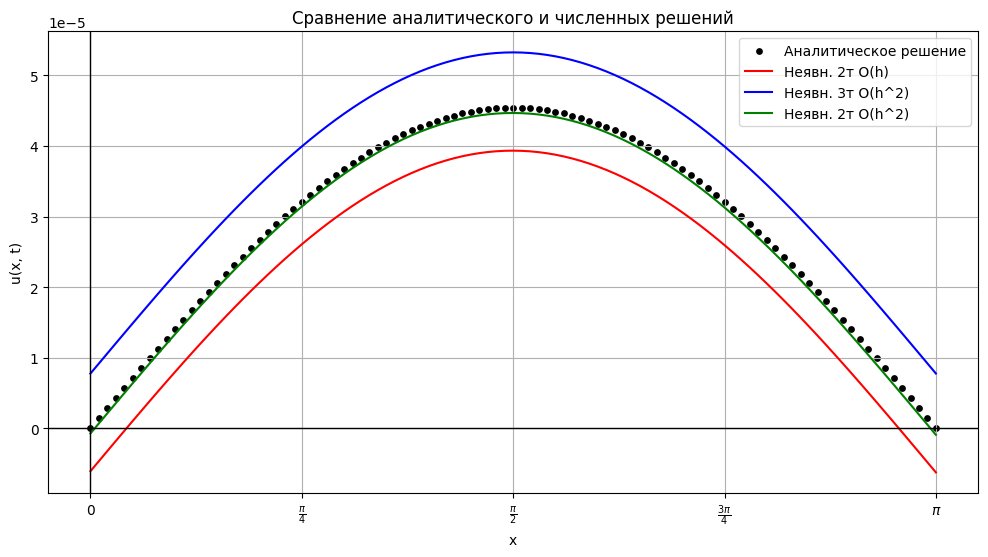

In [31]:
plt.figure(figsize=(12, 6))


plt.scatter(xx, y_true, s=15, color="black", label=f'Аналитическое решение')
plt.plot(xx, y_im1, color="red", label=f'Неявн. 2т O(h)')
plt.plot(xx, y_im2, color="blue", label=f'Неявн. 3т O(h^2)')
plt.plot(xx, y_im3, color="green", label=f'Неявн. 2т O(h^2)')


plt.title('Сравнение аналитического и численных решений')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.xticks(ticks=[0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi], 
           labels=['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'])

# plt.ylim(-0.000025, 0.000025)
# plt.xticks(ticks=[0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2], 
#            labels=['0', r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$'])


plt.grid()
plt.legend()
plt.show()

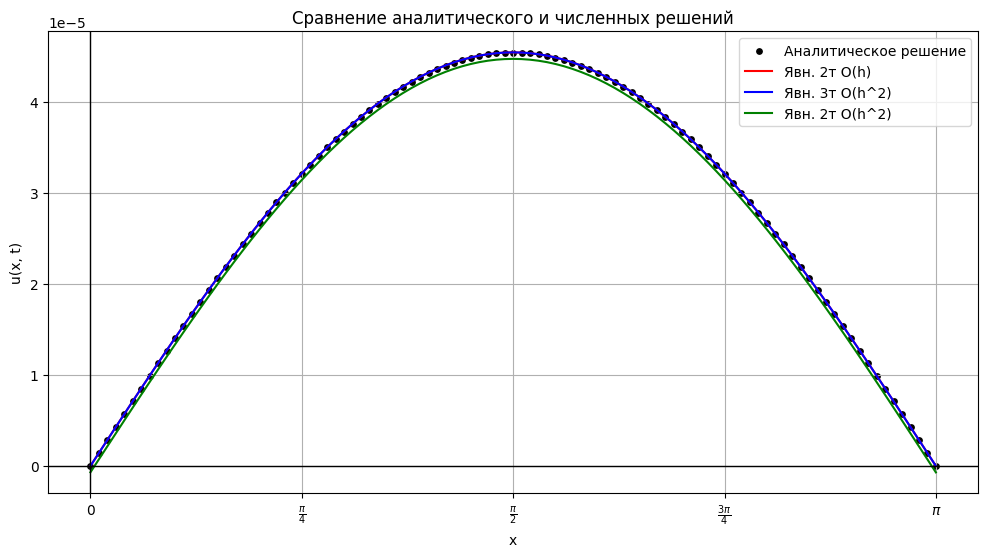

In [32]:
plt.figure(figsize=(12, 6))


plt.scatter(xx, y_true, s=15, color="black", label=f'Аналитическое решение')
plt.plot(xx, y_ex1, color="red", label=f'Явн. 2т O(h)')
plt.plot(xx, y_ex2, color="blue", label=f'Явн. 3т O(h^2)')
plt.plot(xx, y_ex3, color="green", label=f'Явн. 2т O(h^2)')


plt.title('Сравнение аналитического и численных решений')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.xticks(ticks=[0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi], 
           labels=['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'])

# plt.ylim(-0.000025, 0.000025)
# plt.xticks(ticks=[0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2], 
#            labels=['0', r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$'])


plt.grid()
plt.legend()
plt.show()

In [33]:
tt = np.linspace(0, T, K + 1)
mae_ex1 = np.zeros(K+1)
mae_ex2 = np.zeros(K+1)
mae_ex3 = np.zeros(K+1)

mae_im1 = np.zeros(K+1)
mae_im2 = np.zeros(K+1)
mae_im3 = np.zeros(K+1)


for k in range(K+1):
    for i in range(N+1):
        res = analytical_solution(xi(L, i, h), tk(k, τ))
        mae_ex1[k] += np.abs(u_ex1[k,i] - res)
        mae_ex2[k] += np.abs(u_ex2[k,i] - res)
        mae_ex3[k] += np.abs(u_ex3[k,i] - res)

        mae_im1[k] += np.abs(u_im1[k,i] - res)
        mae_im2[k] += np.abs(u_im2[k,i] - res)
        mae_im3[k] += np.abs(u_im3[k,i] - res)


    mae_ex1[k] /= N
    mae_ex2[k] /= N
    mae_ex3[k] /= N

    mae_im1[k] /= N
    mae_im2[k] /= N
    mae_im3[k] /= N

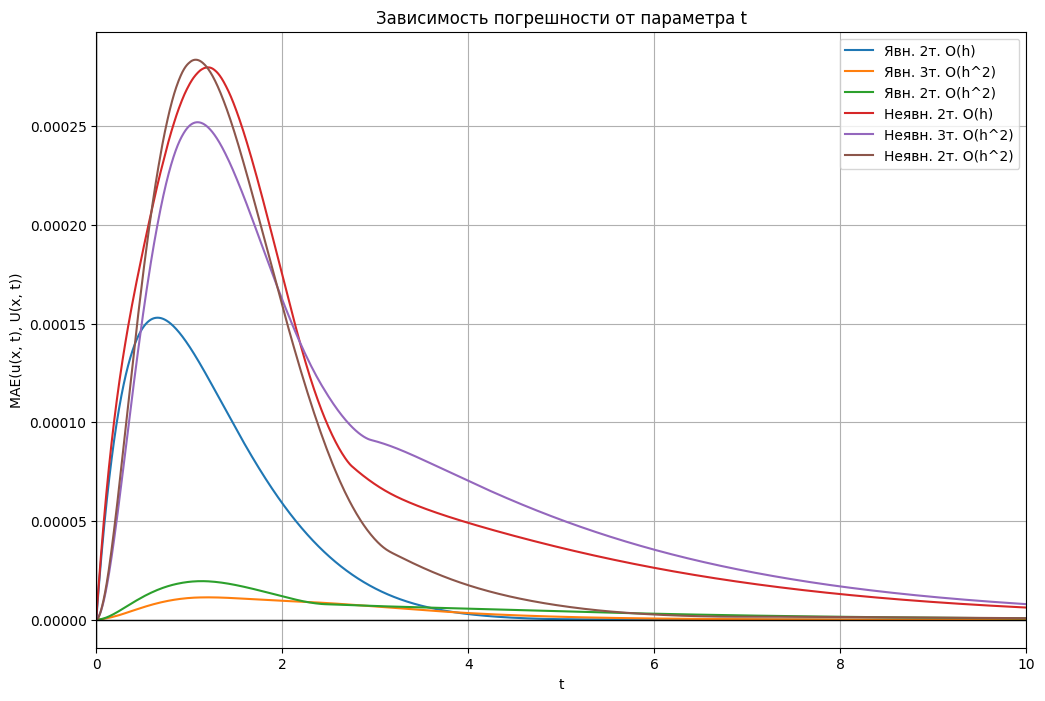

In [34]:
plt.figure(figsize=(12, 8))
plt.plot(tt, mae_ex1, label="Явн. 2т. O(h)")
plt.plot(tt, mae_ex2, label="Явн. 3т. O(h^2)")
plt.plot(tt, mae_ex3, label="Явн. 2т. O(h^2)")

plt.plot(tt, mae_im1, label="Неявн. 2т. O(h)")
plt.plot(tt, mae_im2, label="Неявн. 3т. O(h^2)")
plt.plot(tt, mae_im3, label="Неявн. 2т. O(h^2)")



plt.xlabel('t')
plt.ylabel('MAE(u(x, t), U(x, t))')
plt.title('Зависимость погрешности от параметра t')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.xlim(0, 10)

plt.legend()
plt.grid()
plt.show()